<a href="https://colab.research.google.com/github/Samurai9/Prediction-of-Therapy/blob/main/Prediction_of_Therapy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение

## О проекте

Мы имеем медицинский датасет, содержащий информацию о пациентах, их анализы и файт переведения их в отделение интенсивной терапии. На нём мы можем построить модель для соответствующих предсказаний.

## Задачи проекта

- предобработать полученный датасет

- выделить важные признаки из существующего набора

- обучить различные модели для предсказания стоимости дома

- оценить полученные моделями различными функциями оценивания


##Цель

На имеющихся данных построить модель, которая позволит определить, нуждается ли пациент в переводе в отделение интенсивной терапии или нет.

## Участники

Работу выполнили студенты 3 курса ИТИС Свидиров Кирилл и Насибуллин Эрик группы 11-902.

## Источник данных

Реальные датасеты, содержащие записи о попавших в больницу людях

# Imports

## Загрузка дополнительных библиотек

In [ ]:
! pip install catboost

     |████████████████████████████████| 76.3 MB 1.7 MB/s 


In [ ]:
!pip install chart-studio

     |████████████████████████████████| 64 kB 2.3 MB/s 


In [ ]:
!pip install plotly

## Импорты используемых библиотек и модулей

In [ ]:
#-----<XxXxX>-----#

import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline

#-----<Plotly>-----#
import chart_studio.plotly as py

py.sign_in('OneWayDream', 'R956rptWwcwqhvLztngF')

from plotly.graph_objs import *

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

#-----<Models>-----#

from catboost import CatBoostClassifier, Pool, metrics, cv
import hyperopt
from sklearn.tree import DecisionTreeClassifier
from lightgbm.sklearn import LGBMClassifier

from sklearn.metrics import *

#-----<XxXxX>-----#

# Импорт данных

In [ ]:
link = "https://drive.google.com/uc?export=download&id=1DMQ4BfLu3L9pnIyG-qD9FL7CCwd0kX_S";
dataset = pd.read_csv(link)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (6,7,8,9,10,11,12,13,14,16,18,19,20,21,22,25,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,171,172,173,174,175,176,177,178,179,180,181,182,184,185,186,187,188,189,190,192,193,194,197,198,200,201,202,204,207,208,209,210,211,212,213,214,215,216,217,218,220,221,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,263,264,265,266,267,269,270,271,272,274,275,276,277,278,

In [ ]:
dataset.head()

,Unnamed: 0,КодПациента,Пол,Переведен,Возраст,ВозрастнойПериод,ВидРезультата_Короновирус(COVID-19),ВидРезультата_Д-димер,ВидРезультата_Тропонин I,ВидРезультата_Прокальцитонин,ВидРезультата_Глюкоза 6-00,ВидРезультата_Глюкоза 16-00,ВидРезультата_Чесотка,ВидРезультата_Педикулез,ВидРезультата_Смена Белья,ВидРезультата_SpO2,"ВидРезультата_Антитела к коронавирусу SARS-CoV-2 (COVID-19), IgM",ВидРезультата_ФВ по Teichgolz,ВидРезультата_Трикуспидальная регургитация,ВидРезультата_СДЛА,ВидРезультата_Митральная регургитация,ВидРезультата_КСР,ВидРезультата_КДР,ВидРезультата_Аортальный стеноз,ВидРезультата_Пульс,ВидРезультата_Температура,ВидРезультата_Dia,ВидРезультата_Sis,ВидРезультата_Трикуспидальный стеноз,"ВидРезультата_Антитела к коронавирусу SARS-CoV-2 (COVID-19), IgG",ВидРезультата_Антитела к HBsAg,ВидРезультата_Антитела к HBcore IgM,ВидРезультата_Суммарные Антитела-HBcoreAg гепатита В,ВидРезультата_Процент эозин(EOS%),ВидРезультата_Гематокрит (HCT),ВидРезультата_Процент базоф(BASO%),ВидРезультата_Процент моноц(MONO%),ВидРезультата_Процент лимф(LYM%),ВидРезультата_Процент Нейтроф(NEU%),ВидРезультата_Базофилы (BASO),...,ВидРезультата_Соматотропный гормон,ВидРезультата_t (9,ВидРезультата_Бласты,"ВидРезультата_Генотипирование Гепатита С (генотипы 1а, 1b, 2а, 3а)",ВидРезультата_Кровь,ВидРезультата_Типирование HLA-A(Luminex),ВидРезультата_Типирование HLA-B(Luminex),ВидРезультата_Типирование HLA-DRB1(Luminex),ВидРезультата_Исследование плевральной жидкости,ВидРезультата_Кальцитонин,ВидРезультата_микоплазма пневмония,ВидРезультата_хламидии пневмония,ВидРезультата_Аполипопротеин В,ВидРезультата_Аполипопротеин А-1,ВидРезультата_Scl-70,ВидРезультата_Jo-1,ВидРезультата_Центромера B,ВидРезультата_Sm,ВидРезультата_RNP,ВидРезультата_SS-B,ВидРезультата_SS-A,ВидРезультата_Нуклеосома,ВидРезультата_dsDNA,ВидРезультата_Количество,ВидРезультата_Калий в моче суточный,ВидРезультата_Кортизол,ВидРезультата_Мочевина в моче,ВидРезультата_Токсогенная зернистость нейтрофилов,ВидРезультата_Ретикулоциты,ВидРезультата_Кислотоустойчивые микобактерии в плевральной жидкости,ВидРезультата_Mycobacterium tuberculosis complex,Пребывание(дни),ИсходЗаболевания,Подразделение,ВидТранспортировки,ДоставленВСостоянииАлкогольногоОпьянения,ДоставленВСостоянииНаркотическогоОпьянения,Состояние,СрочностьГоспитализации,ПрофильМедицинскойПомощи
0,0,28,Ж,0,58,Пожилой,положительно 37.5,"0,697","0,001",NaN,"13,5","15,6",-,-,+,93.0,0 Отрицательный,60.0,Рег. (+): 1 степень,33,Рег. (+): 1 степень,"3,5","5,2",2.0,87.0,36.8,88.0,128.0,2.0,"375,6 Положительный","<2,0 Отрицательный","0,000 Отрицательный {ОПкрит.=0,241}","0,042 Положительный",0,"43,7","0,2","5,9","25,7","68,2","0,01",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,улучшение,Приемное отделение терапевтического стационара,Может идти,Нет,Нет,Удовлетворительное,Экстренно,Инфекционные болезни
1,1,77,Ж,0,76,Старческий,"положительно28,5","0,747","0,008",отрицател Отрицательно,"6,9","13,8",NaN,NaN,NaN,95.0,"0,418 Положительный {ОПкрит.=0,205",NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,38.2,80.0,134.0,NaN,412 Положительный,"<2,0 Отрицательный","0,000 Отрицательный {ОПкрит.=0,243}","0,000 Отрицательный","1,9","34,8","0,5","5,8","23,9","67,9","0,03",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,без перемен,Приемное отделение терапевтического стационара,На каталке,Нет,Нет,Удовлетворительное,Экстренно,Инфекционные болезни
2,2,77,Ж,0,76,Старческий,"положительно28,5","0,747","0,008",отрицател Отрицательно,"6,9","13,8",NaN,NaN,NaN,95.0,"0,418 Положительный {ОПкрит.=0,205",NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,38.2,80.0,134.0,NaN,412 Положительный,"<2,0 Отрицательный","0,000 Отрицательный {ОПкрит.=0,243}","0,000 Отрицательный","1,9","34,8","0,5","5,8","23,9","67,9","0,03",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# Предобработка данных

## Оценим размер полученной выборки

In [ ]:
dataset.shape

(27952, 501)

Мы имеем очень большое количество столбцов, из которых явно пригодятся не все

Попробуем отбросить некоторые значения. Даже при просмотре шапки датасета видно, что есть колонки с очень большим количеством пропусков. Отбросим те колоник, в которых процент пропусков больше заданного значения

In [ ]:
a = 0.9
dataset = dataset[dataset.columns[dataset.isna().sum() < dataset.shape[0]*a]]

In [ ]:
dataset.shape

(27952, 67)

In [ ]:
dataset.head()

,Unnamed: 0,КодПациента,Пол,Переведен,Возраст,ВозрастнойПериод,ВидРезультата_Температура,ВидРезультата_Процент эозин(EOS%),ВидРезультата_Гематокрит (HCT),ВидРезультата_Процент базоф(BASO%),ВидРезультата_Процент моноц(MONO%),ВидРезультата_Процент лимф(LYM%),ВидРезультата_Процент Нейтроф(NEU%),ВидРезультата_Базофилы (BASO),ВидРезультата_Эозинофилы (EOS),ВидРезультата_Лимфоциты (LYM),ВидРезультата_Моноциты (MONO),ВидРезультата_Нейтрофилы (NEU),ВидРезультата_Тромбокрит (PCT),ВидРезультата_Средний объем тромб (MPV),ВидРезультата_Ширина распред. тромб. (PDW),ВидРезультата_Коэфф. анизотр. эритр. (RDW-CV),ВидРезультата_Тромбоциты (PLT),ВидРезультата_Сред. конц. гема в эр. (MCHC),ВидРезультата_Сред. сод. гема (MCH),ВидРезультата_Средний объем эритр (MCV),ВидРезультата_Гемоглобин (HGB),ВидРезультата_Эритроциты (RBC),ВидРезультата_Лейкоциты (WBC),ВидРезультата_Глюкоза,ВидРезультата_Билирубин прямой,ВидРезультата_Билирубин общий,ВидРезультата_АСТ,ВидРезультата_АЛТ,ВидРезультата_Холестерин,ВидРезультата_Мочевина,ВидРезультата_Креатинин,ВидРезультата_Общий белок,ВидРезультата_Калий,ВидРезультата_Натрий,ВидРезультата_Хлориды,ВидРезультата_Ферритин,ВидРезультата_Лейкоциты,ВидРезультата_Эпителий плоский,ВидРезультата_Кетоны,ВидРезультата_Удельный вес,ВидРезультата_Кислотность,ВидРезультата_Прозрачность,ВидРезультата_Цвет,ВидРезультата_C-реактивный белок,ВидРезультата_Лактатдегидрогеназа,ВидРезультата_Протромбиновый индекс,ВидРезультата_АЧТВ,ВидРезультата_Фибриноген,ВидРезультата_МНО,"ВидРезультата_Протромбиновое время, сек",ВидРезультата_Незрелые гранулоциты (IG%),ВидРезультата_Кальций общий,Пребывание(дни),ИсходЗаболевания,Подразделение,ВидТранспортировки,ДоставленВСостоянииАлкогольногоОпьянения,ДоставленВСостоянииНаркотическогоОпьянения,Состояние,СрочностьГоспитализации,ПрофильМедицинскойПомощи
0,0,28,Ж,0,58,Пожилой,36.8,0,"43,7","0,2","5,9","25,7","68,2","0,01",0,"1,65","0,38","4,37","0,42","10,5","13,1","12,6",405,339.0,"28,7","84,7",148,"5,16","6,41","9,5","4,2","8,5",27,"78,5","2,87","3,1",57,"67,7","4,9",133,94,"794,9","0,0 4-5 в п-зр",45 4-5 в п/зр,15 Высокий уровень,1 018,6 Слабо-кислая,Прозрачная,Соломенный,"0,5",479,100,"15,3",4,1,"12,3","2,5",NaN,6,улучшение,Приемное отделение терапевтического стационара,Может идти,Нет,Нет,Удовлетворительное,Экстренно,Инфекционные болезни
1,1,77,Ж,0,76,Старческий,38.2,"1,9","34,8","0,5","5,8","23,9","67,9","0,03","0,11","1,4","0,34","3,97","0,3","10,6","12,2","15,9",269,290.0,22,"75,7",101,"4,6","5,85","9,1","1,7","22,8","15,2","2,1","3,42","3,03","67,1","68,7","4,54",140,103,"10,9","35,8","6,6",0 Отрицательный,1 015,Кислая,Прозрачная,Соломенно-желтый,"17,75",667,87,"26,6",400,"1,09","14,3",0,"2,71",4,без перемен,Приемное отделение терапевтического стационара,На каталке,Нет,Нет,Удовлетворительное,Экстренно,Инфекционные болезни
2,2,77,Ж,0,76,Старческий,38.2,"1,9","34,8","0,5","5,8","23,9","67,9","0,03","0,11","1,4","0,34","3,97","0,3","10,6","12,2","15,9",269,290.0,22,"75,7",101,"4,6","5,85","9,1","1,7","22,8","15,2","2,1","3,42","3,03","67,1","68,7","4,54",140,103,"10,9","35,8","6,6",0 Отрицательный,1 015,Кислая,Прозрачная,Соломенно-желтый,"17,75",667,87,"26,6",400,"1,09","14,3",0,"2,71",4,без перемен,Приемное отделение хирургического стационара,На каталке,Нет,Нет,Удовлетворительное,Экстренно,Кардиология
3,3,77,Ж,0,76,Старческий,38.2,"1,9","34,8","0,5","5,8","23,9","67,9","0,03","0,11","1,4","0,34","3,97","0,3","10,6","12,2","15,9",269,290.0,22,"75,7",101,"4,6","5,85","9,1","1,7","22,8","15,2","2,1","3,42","3,03","67,1","68,7","4,54",140,103,"10,9","35,8","6,6",0 Отрицательный,1 015,Кислая,Прозрачная,Соломенно-желтый,"17,75",667,87,"26,6",400,"1,09","14,3",0,"2,71",4,умер,Приемное отделение терапевтического стационара,На каталке,Нет,Нет,Удовлетворительное,Экстренно,Инфекционные болезни
4,4,77,Ж,0,76,Старческий,38.2,"1,9","34,8","0,5","5,8","23,9","67,9","0,03","0,11","1,4","0,34","3,97","0,3","10,6","12,2","15,9",269,290.0,22,"75,7",101,"4,6","5,85","9,1","1,7","22,8","15,2","2,1","3,42","3,03","67

Нам успешно удалось уменьшить количество колонок, будем работать с ними. Но данные очень сильно разрежены, и нам придётся их обработать

## Преобразование типов и обработка пропущенных значений

Проверим, какие строки нуждаются в преобразовании


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27952 entries, 0 to 27951
Data columns (total 67 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Unnamed: 0                                     27952 non-null  int64  
 1   КодПациента                                    27952 non-null  int64  
 2   Пол                                            27952 non-null  object 
 3   Переведен                                      27952 non-null  int64  
 4   Возраст                                        27952 non-null  int64  
 5   ВозрастнойПериод                               25794 non-null  object 
 6   ВидРезультата_Температура                      6726 non-null   object 
 7   ВидРезультата_Процент эозин(EOS%)              3766 non-null   object 
 8   ВидРезультата_Гематокрит (HCT)                 3766 non-null   object 
 9   ВидРезультата_Процент базоф(BASO%)             376

Все числовые значения имеют тип Object - нужно исправить!

Напишем функцию, которая будет заменять пустые и некорректные значения в столбцах на средние

In [ ]:
def insert_mean(column):
  mean = column[column.isna() | column.str.match("^[0-9\.,]+$")].apply(lambda x: str(x).replace(' .', '.')).apply(lambda x: str(x).replace(',', '.')).astype("float").mean();
  column = column.fillna(mean)
  column[column.str.match("^[0-9\.,]+$") == False] = mean;
  column = column.apply(lambda x: str(x).replace(' .', '.')).apply(lambda x: str(x).replace(',', '.')).astype("float");
  return column;


Преобразуем все столбцы, которые можно так преобразовать

In [ ]:
dataset['ВидРезультата_Температура'] = insert_mean(dataset['ВидРезультата_Температура']);
dataset['ВидРезультата_Процент эозин(EOS%)'] = insert_mean(dataset['ВидРезультата_Процент эозин(EOS%)']);
dataset['ВидРезультата_Гематокрит (HCT)'] = insert_mean(dataset['ВидРезультата_Гематокрит (HCT)']);
dataset['ВидРезультата_Процент базоф(BASO%)'] = insert_mean(dataset['ВидРезультата_Процент базоф(BASO%)']);
dataset['ВидРезультата_Процент моноц(MONO%)'] = insert_mean(dataset['ВидРезультата_Процент моноц(MONO%)']);
dataset['ВидРезультата_Нейтрофилы (NEU)'] = insert_mean(dataset['ВидРезультата_Нейтрофилы (NEU)']);
dataset['ВидРезультата_Тромбокрит (PCT)'] = insert_mean(dataset['ВидРезультата_Тромбокрит (PCT)']);
dataset['ВидРезультата_Средний объем тромб (MPV)'] = insert_mean(dataset['ВидРезультата_Средний объем тромб (MPV)']);
dataset['ВидРезультата_Ширина распред. тромб. (PDW)'] = insert_mean(dataset['ВидРезультата_Ширина распред. тромб. (PDW)']);
dataset['ВидРезультата_Коэфф. анизотр. эритр. (RDW-CV)'] = insert_mean(dataset['ВидРезультата_Коэфф. анизотр. эритр. (RDW-CV)']);
dataset['ВидРезультата_Тромбоциты (PLT)'] = insert_mean(dataset['ВидРезультата_Тромбоциты (PLT)']);

dataset['ВидРезультата_Сред. конц. гема в эр. (MCHC)'] = dataset['ВидРезультата_Сред. конц. гема в эр. (MCHC)'].fillna(dataset['ВидРезультата_Сред. конц. гема в эр. (MCHC)'].mean())

dataset['ВидРезультата_Сред. сод. гема (MCH)'] = insert_mean(dataset['ВидРезультата_Сред. сод. гема (MCH)']);
dataset['ВидРезультата_Средний объем эритр (MCV)'] = insert_mean(dataset['ВидРезультата_Средний объем эритр (MCV)']);
dataset['ВидРезультата_Гемоглобин (HGB)'] = insert_mean(dataset['ВидРезультата_Гемоглобин (HGB)']);
dataset['ВидРезультата_Эритроциты (RBC)'] = insert_mean(dataset['ВидРезультата_Эритроциты (RBC)']);
dataset['ВидРезультата_Лейкоциты (WBC)'] = insert_mean(dataset['ВидРезультата_Лейкоциты (WBC)']);
dataset['ВидРезультата_Глюкоза'] = insert_mean(dataset['ВидРезультата_Глюкоза']);
dataset['ВидРезультата_Билирубин прямой'] = insert_mean(dataset['ВидРезультата_Билирубин прямой']);
dataset['ВидРезультата_Билирубин общий'] = insert_mean(dataset['ВидРезультата_Билирубин общий']);
dataset['ВидРезультата_АСТ'] = insert_mean(dataset['ВидРезультата_АСТ']);
dataset['ВидРезультата_Холестерин'] = insert_mean(dataset['ВидРезультата_Холестерин']);
dataset['ВидРезультата_Мочевина'] = insert_mean(dataset['ВидРезультата_Мочевина']);
dataset['ВидРезультата_Креатинин'] = insert_mean(dataset['ВидРезультата_Креатинин']);
dataset['ВидРезультата_Общий белок'] = insert_mean(dataset['ВидРезультата_Общий белок']);
dataset['ВидРезультата_Калий'] = insert_mean(dataset['ВидРезультата_Калий']);
dataset['ВидРезультата_Натрий'] = insert_mean(dataset['ВидРезультата_Натрий']);
dataset['ВидРезультата_Хлориды'] = insert_mean(dataset['ВидРезультата_Хлориды']);
dataset['ВидРезультата_Ферритин'] = insert_mean(dataset['ВидРезультата_Ферритин']);
dataset['ВидРезультата_Лейкоциты'] = insert_mean(dataset['ВидРезультата_Лейкоциты']);
dataset['ВидРезультата_Эпителий плоский'] = insert_mean(dataset['ВидРезультата_Эпителий плоский']);
dataset['ВидРезультата_Удельный вес'] = insert_mean(dataset['ВидРезультата_Удельный вес']);
dataset['ВидРезультата_C-реактивный белок'] = insert_mean(dataset['ВидРезультата_C-реактивный белок']);
dataset['ВидРезультата_Лактатдегидрогеназа'] = insert_mean(dataset['ВидРезультата_Лактатдегидрогеназа']);
dataset['ВидРезультата_Протромбиновый индекс'] = insert_mean(dataset['ВидРезультата_Протромбиновый индекс']);
dataset['ВидРезультата_АЧТВ'] = insert_mean(dataset['ВидРезультата_АЧТВ']);
dataset['ВидРезультата_Фибриноген'] = insert_mean(dataset['ВидРезультата_Фибриноген']);
dataset['ВидРезультата_МНО'] = insert_mean(dataset['ВидРезультата_МНО']);
dataset['ВидРезультата_Протромбиновое время, сек'] = insert_mean(dataset['ВидРезультата_Протромбиновое время, сек']);
dataset['ВидРезультата_Незрелые гранулоциты (IG%)'] = insert_mean(dataset['ВидРезультата_Незрелые гранулоциты (IG%)']);
dataset['ВидРезультата_Кальций общий'] = insert_mean(dataset['ВидРезультата_Кальций общий']);
dataset['ВидРезультата_Процент лимф(LYM%)'] = insert_mean(dataset['ВидРезультата_Процент лимф(LYM%)']);
dataset['ВидРезультата_Процент Нейтроф(NEU%)'] = insert_mean(dataset['ВидРезультата_Процент Нейтроф(NEU%)']);
dataset['ВидРезультата_Базофилы (BASO)'] = insert_mean(dataset['ВидРезультата_Базофилы (BASO)']);
dataset['ВидРезультата_Эозинофилы (EOS)'] = insert_mean(dataset['ВидРезультата_Эозинофилы (EOS)']);
dataset['ВидРезультата_Лимфоциты (LYM)'] = insert_mean(dataset['ВидРезультата_Лимфоциты (LYM)']);
dataset['ВидРезультата_Моноциты (MONO)'] = insert_mean(dataset['ВидРезультата_Моноциты (MONO)']);
dataset['ВидРезультата_АЛТ'] = insert_mean(dataset['ВидРезультата_АЛТ']);

Теперь обработаем пропущенные категориальные признаки

In [ ]:
dataset['ВидРезультата_Кислотность'].value_counts()

Кислая              1630
6,5 Слабо-кислая     396
5 Кислая             340
6 Слабо-кислая       183
8 Щелочная            66
Нейтральная           50
7 Нейтральная         45
Резко-щелоная         27
Щелочная              26
9 Резко-щелочная      26
Нет значения          18
5,5 Кислая             7
Слабо-кислая           6
7,5 Щелочная           1
Name: ВидРезультата_Кислотность, dtype: int64

In [ ]:
dataset['ВидРезультата_Кислотность'] = dataset['ВидРезультата_Кислотность'].fillna("Кислая")
dataset.loc[dataset['ВидРезультата_Кислотность'] == '5 Кислая', 'ВидРезультата_Кислотность'] = "Кислая"
dataset.loc[dataset['ВидРезультата_Кислотность'] == '5,5 Кислая', 'ВидРезультата_Кислотность'] = "Кислая"
dataset.loc[dataset['ВидРезультата_Кислотность'] == '6 Слабо-кислая', ['ВидРезультата_Кислотность']] = "Слабо-кислая"
dataset.loc[dataset['ВидРезультата_Кислотность'] == '6,5 Слабо-кислая', ['ВидРезультата_Кислотность']] = "Слабо-кислая"
dataset.loc[dataset['ВидРезультата_Кислотность'] == '7 Нейтральная', ['ВидРезультата_Кислотность']] = "Нейтральная"
dataset.loc[dataset['ВидРезультата_Кислотность'] == 'Нет значения', ['ВидРезультата_Кислотность']] = "Нейтральная"
dataset.loc[dataset['ВидРезультата_Кислотность'] == '7,5 Щелочная', ['ВидРезультата_Кислотность']] = "Щелочная"
dataset.loc[dataset['ВидРезультата_Кислотность'] == '8 Щелочная', ['ВидРезультата_Кислотность']] = "Щелочная"
dataset.loc[dataset['ВидРезультата_Кислотность'] == '9 Резко-щелочная', ['ВидРезультата_Кислотность']] = "Резко-щелочная"
dataset.loc[dataset['ВидРезультата_Кислотность'] == 'Резко-щелоная', ['ВидРезультата_Кислотность']] = "Резко-щелочная"

In [ ]:
dataset['ВидРезультата_Кислотность'].value_counts()

Кислая            27108
Слабо-кислая        585
Нейтральная         113
Щелочная             93
Резко-щелочная       53
Name: ВидРезультата_Кислотность, dtype: int64

In [ ]:
dataset['ВидРезультата_Кетоны'].value_counts()

0 Отрицательный                     2093
0 Отрицательно                       435
0,5 Слабоположительный               109
1 Положительно                        70
Отрицательно                          43
5 Средний уровень                     26
1,5 Низкий уровень                    19
Слабо положительная                    7
15 Высокий уровень                     7
Положительно ++                        4
Положительно +++                       4
0 +                                    3
Положительно +                         3
0 ПОЛОЖИТЕЛЬНО - средний уровень       2
отрицательно                           2
Положительно (+++)                     1
0 +++                                  1
Name: ВидРезультата_Кетоны, dtype: int64

In [ ]:
dataset['ВидРезультата_Кетоны'] = dataset['ВидРезультата_Кетоны'].fillna("0 Отрицательный")
dataset.loc[dataset['ВидРезультата_Кетоны'] == '0 Отрицательно', 'ВидРезультата_Кетоны'] = "0 Отрицательный"
dataset.loc[dataset['ВидРезультата_Кетоны'] == 'Отрицательно', 'ВидРезультата_Кетоны'] = "0 Отрицательный"
dataset.loc[dataset['ВидРезультата_Кетоны'] == 'отрицательно', 'ВидРезультата_Кетоны'] = "0 Отрицательный"
dataset.loc[dataset['ВидРезультата_Кетоны'] == 'Слабо положительная', 'ВидРезультата_Кетоны'] = "0,5 Слабоположительный"
dataset.loc[dataset['ВидРезультата_Кетоны'] == '1,5 Низкий уровень', 'ВидРезультата_Кетоны'] = "0,5 Слабоположительный"
dataset.loc[dataset['ВидРезультата_Кетоны'] == '1 Положительно', 'ВидРезультата_Кетоны'] = "Положительный +"
dataset.loc[dataset['ВидРезультата_Кетоны'] == 'Положительно +', 'ВидРезультата_Кетоны'] = "Положительный +"
dataset.loc[dataset['ВидРезультата_Кетоны'] == '0 ПОЛОЖИТЕЛЬНО - средний уровень', 'ВидРезультата_Кетоны'] = "Положительный +"
dataset.loc[dataset['ВидРезультата_Кетоны'] == '0 +', 'ВидРезультата_Кетоны'] = "Положительный +"
dataset.loc[dataset['ВидРезультата_Кетоны'] == 'Положительно ++', 'ВидРезультата_Кетоны'] = "Положительный ++"
dataset.loc[dataset['ВидРезультата_Кетоны'] == '5 Средний уровень', 'ВидРезультата_Кетоны'] = "Положительный ++"
dataset.loc[dataset['ВидРезультата_Кетоны'] == 'Положительно (+++)', 'ВидРезультата_Кетоны'] = "Положительный +++"
dataset.loc[dataset['ВидРезультата_Кетоны'] == '0 +++', 'ВидРезультата_Кетоны'] = "Положительный +++"
dataset.loc[dataset['ВидРезультата_Кетоны'] == 'Положительно +++', 'ВидРезультата_Кетоны'] = "Положительный +++"
dataset.loc[dataset['ВидРезультата_Кетоны'] == '15 Высокий уровень', 'ВидРезультата_Кетоны'] = "Положительный +++"

In [ ]:
dataset['ВидРезультата_Кетоны'].value_counts()

0 Отрицательный           27696
0,5 Слабоположительный      135
Положительный +              78
Положительный ++             30
Положительный +++            13
Name: ВидРезультата_Кетоны, dtype: int64

In [ ]:
dataset['ВидРезультата_Прозрачность'].value_counts()

Прозрачная      1646
Прозрачный       736
Мутная           267
Слека мутный      82
Неполная          82
прозрачная         4
Мутный             3
мутноватая         1
Name: ВидРезультата_Прозрачность, dtype: int64

In [ ]:
dataset['ВидРезультата_Прозрачность'] = dataset['ВидРезультата_Прозрачность'].fillna("Прозрачная")
dataset.loc[dataset['ВидРезультата_Прозрачность'] == 'Прозрачный', 'ВидРезультата_Прозрачность'] = "Прозрачная"
dataset.loc[dataset['ВидРезультата_Прозрачность'] == 'прозрачный', 'ВидРезультата_Прозрачность'] = "Прозрачная"
dataset.loc[dataset['ВидРезультата_Прозрачность'] == 'прозрачная', 'ВидРезультата_Прозрачность'] = "Прозрачная"
dataset.loc[dataset['ВидРезультата_Прозрачность'] == 'Слека мутный', 'ВидРезультата_Прозрачность'] = "Слегка Мутная"
dataset.loc[dataset['ВидРезультата_Прозрачность'] == 'мутноватая', 'ВидРезультата_Прозрачность'] = "Слегка Мутная"
dataset.loc[dataset['ВидРезультата_Прозрачность'] == 'Мутный', 'ВидРезультата_Прозрачность'] = "Мутная"

In [ ]:
dataset['ВидРезультата_Прозрачность'].value_counts()

Прозрачная       27517
Мутная             270
Слегка Мутная       83
Неполная            82
Name: ВидРезультата_Прозрачность, dtype: int64

In [ ]:
dataset['ВидРезультата_Цвет'].value_counts()

Соломенно-желтый       1255
Желтый                  850
Светло-желтый           207
Янтраный                160
Соломенный              140
Бледно-желтый           109
Коричневый               75
Беловатая                28
Серовато-беловатый       22
красный                   9
Желтоватая                9
светло-желтый             8
Насыщенно-желтый          3
кровянистая               2
бледно-зеленый            1
темно-коричневая          1
Желто-зеленая             1
Желтовато-сероватый       1
зелено-желтый             1
бесцветная                1
серая                     1
Name: ВидРезультата_Цвет, dtype: int64

In [ ]:
dataset['ВидРезультата_Цвет'] = dataset['ВидРезультата_Цвет'].fillna("Соломенно-желтый")
dataset.loc[dataset['ВидРезультата_Цвет'] == 'Соломенный', 'ВидРезультата_Цвет'] = "Соломенно-желтый"
dataset.loc[dataset['ВидРезультата_Цвет'] == 'Насыщенно-желтый', 'ВидРезультата_Цвет'] = "Желтый"
dataset.loc[dataset['ВидРезультата_Цвет'] == 'светло-желтый', 'ВидРезультата_Цвет'] = "Светло-желтый"
dataset.loc[dataset['ВидРезультата_Цвет'] == 'светло-желтый', 'ВидРезультата_Цвет'] = "Светло-желтый"
dataset.loc[dataset['ВидРезультата_Цвет'] == 'зелено-желтый', 'ВидРезультата_Цвет'] = "Желто-зеленый"
dataset.loc[dataset['ВидРезультата_Цвет'] == 'Желто-зеленая', 'ВидРезультата_Цвет'] = "Желто-зеленый"
dataset.loc[dataset['ВидРезультата_Цвет'] == 'кровянистая', 'ВидРезультата_Цвет'] = "красный"
dataset.loc[dataset['ВидРезультата_Цвет'] == 'красный', 'ВидРезультата_Цвет'] = "Красный"
dataset.loc[dataset['ВидРезультата_Цвет'] == 'бесцветная', 'ВидРезультата_Цвет'] = "Другое"
dataset.loc[dataset['ВидРезультата_Цвет'] == 'серая', 'ВидРезультата_Цвет'] = "Другое"
dataset.loc[dataset['ВидРезультата_Цвет'] == 'Желтовато-сероватый', 'ВидРезультата_Цвет'] = "Другое"
dataset.loc[dataset['ВидРезультата_Цвет'] == 'темно-коричневая', 'ВидРезультата_Цвет'] = "Другое"
dataset.loc[dataset['ВидРезультата_Цвет'] == 'бледно-зеленый', 'ВидРезультата_Цвет'] = "Другое"
dataset.loc[dataset['ВидРезультата_Цвет'] == 'Желто-зеленый', 'ВидРезультата_Цвет'] = "Другое"

In [ ]:
dataset['ВидРезультата_Цвет'].value_counts()

Соломенно-желтый      26463
Желтый                  853
Светло-желтый           215
Янтраный                160
Бледно-желтый           109
Коричневый               75
Беловатая                28
Серовато-беловатый       22
Красный                  11
Желтоватая                9
Другое                    7
Name: ВидРезультата_Цвет, dtype: int64

Теперь убедимся, что в наших данных не осталось пропусков, и обретём душевный покой (наконец-то...)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27952 entries, 0 to 27951
Data columns (total 67 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Unnamed: 0                                     27952 non-null  int64  
 1   КодПациента                                    27952 non-null  int64  
 2   Пол                                            27952 non-null  object 
 3   Переведен                                      27952 non-null  int64  
 4   Возраст                                        27952 non-null  int64  
 5   ВозрастнойПериод                               25794 non-null  object 
 6   ВидРезультата_Температура                      27952 non-null  float64
 7   ВидРезультата_Процент эозин(EOS%)              27952 non-null  float64
 8   ВидРезультата_Гематокрит (HCT)                 27952 non-null  float64
 9   ВидРезультата_Процент базоф(BASO%)             279

In [ ]:
dataset.corr().style.format("{:.2}").background_gradient(cmap='coolwarm', axis=1)

# Подготовка к обучению

## Нормализация данных

In [ ]:
prepared_dataset = dataset.copy()

In [ ]:
prepared_dataset.drop("Unnamed: 0", 1, inplace=True) # Идентификатор пациента нас не интересует
prepared_dataset.drop("КодПациента", 1, inplace=True) # Как и код
prepared_dataset.drop("ИсходЗаболевания", 1, inplace=True) # Исход заболевания - категориальный, и одна из категорий - смерть. Не самый лучший критерий для перевода в интенсивную терапию :\
prepared_dataset.fillna('', inplace=True)
prepared_dataset

,Пол,Переведен,Возраст,ВозрастнойПериод,ВидРезультата_Температура,ВидРезультата_Процент эозин(EOS%),ВидРезультата_Гематокрит (HCT),ВидРезультата_Процент базоф(BASO%),ВидРезультата_Процент моноц(MONO%),ВидРезультата_Процент лимф(LYM%),ВидРезультата_Процент Нейтроф(NEU%),ВидРезультата_Базофилы (BASO),ВидРезультата_Эозинофилы (EOS),ВидРезультата_Лимфоциты (LYM),ВидРезультата_Моноциты (MONO),ВидРезультата_Нейтрофилы (NEU),ВидРезультата_Тромбокрит (PCT),ВидРезультата_Средний объем тромб (MPV),ВидРезультата_Ширина распред. тромб. (PDW),ВидРезультата_Коэфф. анизотр. эритр. (RDW-CV),ВидРезультата_Тромбоциты (PLT),ВидРезультата_Сред. конц. гема в эр. (MCHC),ВидРезультата_Сред. сод. гема (MCH),ВидРезультата_Средний объем эритр (MCV),ВидРезультата_Гемоглобин (HGB),ВидРезультата_Эритроциты (RBC),ВидРезультата_Лейкоциты (WBC),ВидРезультата_Глюкоза,ВидРезультата_Билирубин прямой,ВидРезультата_Билирубин общий,ВидРезультата_АСТ,ВидРезультата_АЛТ,ВидРезультата_Холестерин,ВидРезультата_Мочевина,ВидРезультата_Креатинин,ВидРезультата_Общий белок,ВидРезультата_Калий,ВидРезультата_Натрий,ВидРезультата_Хлориды,ВидРезультата_Ферритин,ВидРезультата_Лейкоциты,ВидРезультата_Эпителий плоский,ВидРезультата_Кетоны,ВидРезультата_Удельный вес,ВидРезультата_Кислотность,ВидРезультата_Прозрачность,ВидРезультата_Цвет,ВидРезультата_C-реактивный белок,ВидРезультата_Лактатдегидрогеназа,ВидРезультата_Протромбиновый индекс,ВидРезультата_АЧТВ,ВидРезультата_Фибриноген,ВидРезультата_МНО,"ВидРезультата_Протромбиновое время, сек",ВидРезультата_Незрелые гранулоциты (IG%),ВидРезультата_Кальций общий,Пребывание(дни),Подразделение,ВидТранспортировки,ДоставленВСостоянииАлкогольногоОпьянения,ДоставленВСостоянииНаркотическогоОпьянения,Состояние,СрочностьГоспитализации,ПрофильМедицинскойПомощи
0,Ж,0,58,Пожилой,36.800000,0.000000,43.700000,0.200000,5.900000,25.700000,68.200000,0.010000,0.000000,1.650000,0.380000,4.37000,0.420000,10.500000,13.100000,12.600000,405.00000,339.00000,28.700000,84.700000,148.000000,5.160000,6.410000,9.500000,4.200000,8.500000,27.000000,78.500000,2.87000,3.100000,57.00000,67.700000,4.90000,133.000000,94.000000,794.900000,18.808681,11.41733,Положительный +++,1.016217,Слабо-кислая,Прозрачная,Соломенно-желтый,0.500000,479.000000,100.000000,15.30000,4.000000,1.00000,12.300000,2.500000,2.332858,6,Приемное отделение терапевтического стационара,Может идти,Нет,Нет,Удовлетворительное,Экстренно,Инфекционные болезни
1,Ж,0,76,Старческий,38.200000,1.900000,34.800000,0.500000,5.800000,23.900000,67.900000,0.030000,0.110000,1.400000,0.340000,3.97000,0.300000,10.600000,12.200000,15.900000,269.00000,290.00000,22.000000,75.700000,101.000000,4.600000,5.850000,9.100000,1.700000,22.800000,15.200000,2.100000,3.42000,3.030000,67.10000,68.700000,4.54000,140.000000,103.000000,10.900000,35.800000,6.60000,0 Отрицательный,1.016217,Кислая,Прозрачная,Соломенно-желтый,17.750000,667.000000,87.000000,26.60000,400.000000,1.09000,14.300000,0.000000,2.710000,4,Приемное отделение терапевтического стационара,На каталке,Нет,Нет,Удовлетворительное,Экстренно,Инфекционные болезни
2,Ж,0,76,Старческий,38.200000,1.900000,34.800000,0.500000,5.800000,23.900000,67.900000,0.030000,0.110000,1.400000,0.340000,3.97000,0.300000,10.600000,12.200000,15.900000,269.00000,290.00000,22.000000,75.700000,101.000000,4.600000,5.850000,9.100000,1.700000,22.800000,15.200000,2.100000,3.42000,3.030000,67.10000,68.700000,4.54000,140.000000,103.000000,10.900000,35.800000,6.60000,0 Отрицательный,1.016217,Кислая,Прозрачная,Соломенно-желтый,17.750000,667.000000,87.000000,26.60000,400.000000,1.09000,14.300000,0.000000,2.710000,4,Приемное отделение хирургического стационара,На каталке,Нет,Нет,Удовлетворительное,Экстренно,Кардиология
3,Ж,0,76,Старческий,38.200000,1.900000,34.800000,0.500000,5.800000,23.900000,67.900000,0.030000,0.110000,1.400000,0.340000,3.97000,0.300000,10.600000,12.200000,15.900000,269.00000,290.00000,22.000000,75.700000,101.000000,4.600000,5.850000,9.100000,1.700000,22.800000,15.200000,2.100000,3.42000,3.03000

## Создание выборки

In [ ]:
from sklearn.model_selection import train_test_split

y = prepared_dataset["Переведен"]
x = prepared_dataset.drop("Переведен", axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1/5, random_state=0)

# Обучение моделей и их оценивание

## Предисловие 


In [ ]:
dataset["Переведен"].value_counts()

0    24674
1     3278
Name: Переведен, dtype: int64

### В качестве оценок мы решили взять следующие четыре:

**Recall** - какую часть людей, которых нужно было перевести в отделение интенсивной терапии, мы действительно перевели. 

Данная оценка, очевидно, должна стремиться к единице - мы должны оказать должную медицинскую помощь всем людям, которым она требуется. С другой стороны, это не самая лучшая оценка для её максимизации - модель может отправлять в отделение всех людей, и оценка будет максимальной. Но это не то, что нам нужно)

**Precision** - точность определения : какое количество из людей, которых мы перевели в отделение интенсивной терапии, действительно нуждались в этом. 

Эта оценка уже является более полезной - модель не будет классифицировать всех в одно множество, ибо в таком случае точность будет крайне мала.

С другой стороны, модель может быть очень строгой к переводу людей в отделение интенсивной терапии - а это плохо.

**Accuracy** - доля правильных ответов. Не самая удачная оценка для несбалансированных выборок (а у нас действительно нулей больше, чем единиц), но главная задача - чтобы модель не ушла в крайность выдачи константы. 

**ROC-AUC** - кривая ошибки, которая также хорошо иллюстрирует результат работы модели и позволяет визуализировать результат классификации модели

## CatBoost

### Подбор гиперпараметров

In [ ]:
def hyperopt_recall_objective(params): # функция подбора лучших параметров для наилучшей recall оценки
    model = CatBoostClassifier( # Создаём модель
        l2_leaf_reg=int(params['l2_leaf_reg']), # из параметров берём гипер-параметр l2_leaf_reg
        # l2_leaf_reg - используем L2-регуляризацию, то есть штрафуем модель за очень большие веса (т.е. боремся с переобучением)
        learning_rate=params['learning_rate'], # из параметров берём гипер-параметр learning_rate
        # learning_rate - размер шага-приближения
        iterations=500, # iteration - максимальное количество деревьев в ансамбле
        eval_metric=metrics.Recall(), # задаём метрику, по которой Catboost будет регулировать свои внутренние параметры
        random_seed=42, # фиксируем random_seed, чтобы каждый раз получать одну и ту же ошибку
        verbose=False, # отключаем объёмное логирование от Catboost
        loss_function=metrics.Logloss(), # В качестве функции потерь при подборе весов задаём LogLoss()
    )
    
    cv_data = cv( # Создаём класс CatBoost для крос-валидации
        Pool(x, y, cat_features=categorical_features_indices), # Передаём набор для обучения моделей, отдельно выделяем категориальные признаки
        model.get_params(), # передаём параметры модели
        logging_level='Silent', # глушим логирование
    )
    best_recall = np.max(cv_data['test-Recall-mean']) # вытаскиваем наилучшую оценку для данных параметров
    
    return 1 - best_recall # возвращаем ошибку модели - эта величина будет минимизироваться

def hyperopt_accuracy_objective(params): # функция подбора лучших параметров для наилучшей accuracy оценки
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500, 
        eval_metric=metrics.Accuracy(),
        random_seed=42,
        verbose=False,
        loss_function=metrics.Logloss(),
    )
    
    cv_data = cv(
        Pool(x, y, cat_features=categorical_features_indices),
        model.get_params(),
        logging_level='Silent',
    )
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy

def hyperopt_precision_objective(params): # функция подбора лучших параметров для наилучшей precision оценки
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500, 
        eval_metric=metrics.Precision(),
        random_seed=42,
        verbose=False,
        loss_function=metrics.Logloss(),
    )
    
    cv_data = cv(
        Pool(x, y, cat_features=categorical_features_indices),
        model.get_params(),
        logging_level='Silent',
    )
    best_precision = np.max(cv_data['test-Precision-mean'])
    
    return 1 - best_precision

def hyperopt_auc_objective(params): # функция подбора лучших параметров для наилучшей auc оценки
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500, 
        eval_metric=metrics.AUC(),
        random_seed=42,
        verbose=False,
        loss_function=metrics.Logloss(),
    )
    
    cv_data = cv(
        Pool(x, y, cat_features=categorical_features_indices),
        model.get_params(),
        logging_level='Silent',
    )
    best_auc = np.max(cv_data['test-AUC-mean'])
    
    return 1 - best_auc     

In [ ]:
from numpy.random import RandomState

categorical_features_indices = np.where(x.dtypes != float)[0] # определяем отдельно все категориальные признаки для модели

params_space = { # генерируем массив параметров для перебора
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

In [ ]:
trials = hyperopt.Trials() # Влияем на результат, который вернёт функция hyperopt.fmin(). Так мы говорим, что хотим получить параметры, для которых наша оценка была максимальной

best_recall = hyperopt.fmin( # Вызываем функцию перебора параметров
    hyperopt_recall_objective, # передаём функцию, написанную выше
    space=params_space, # передаём параметры для перебора
    algo=hyperopt.tpe.suggest, # алгоритм для перебора - этот базируется на Tree of Parzen Estimators (TPE)
    max_evals=10, # останавливаем перебор на определённом количестве операций - они слишком много весят
    trials=trials, # передаём параметр вывода
    rstate=RandomState(123) # фиксируем rstate, чтобы получать одни и те же параметры
)

print(best_recall)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

100%|██████████| 10/10 [19:04<00:00, 114.47s/it, best loss: 0.11378826520638052]
{'l2_leaf_reg': 3.0, 'learning_rate': 0.3792597898539243}


In [ ]:
trials = hyperopt.Trials() # Влияем на результат, который вернёт функция hyperopt.fmin(). Так мы говорим, что хотим получить параметры, для которых наша оценка была максимальной

best_accuracy = hyperopt.fmin( # Вызываем функцию перебора параметров
    hyperopt_accuracy_objective, # передаём функцию, написанную выше
    space=params_space, # передаём параметры для перебора
    algo=hyperopt.tpe.suggest, # алгоритм для перебора - этот базируется на Tree of Parzen Estimators (TPE)
    max_evals=10, # останавливаем перебор на определённом количестве операций - они слишком много весят
    trials=trials, # передаём параметр вывода
    rstate=RandomState(123) # фиксируем rstate, чтобы получать одни и те же параметры
)

print(best_accuracy)

100%|██████████| 10/10 [18:37<00:00, 111.80s/it, best loss: 0.02296801440310159]
{'l2_leaf_reg': 3.0, 'learning_rate': 0.3792597898539243}


In [ ]:
trials = hyperopt.Trials() # Влияем на результат, который вернёт функция hyperopt.fmin(). Так мы говорим, что хотим получить параметры, для которых наша оценка была максимальной

best_precision = hyperopt.fmin( # Вызываем функцию перебора параметров
    hyperopt_precision_objective, # передаём функцию, написанную выше
    space=params_space, # передаём параметры для перебора
    algo=hyperopt.tpe.suggest, # алгоритм для перебора - этот базируется на Tree of Parzen Estimators (TPE)
    max_evals=10, # останавливаем перебор на определённом количестве операций - они слишком много весят
    trials=trials, # передаём параметр вывода
    rstate=RandomState(123) # фиксируем rstate, чтобы получать одни и те же параметры
)

print(best_precision)

100%|██████████| 10/10 [19:16<00:00, 115.69s/it, best loss: 0.07527670326610503]
{'l2_leaf_reg': 3.0, 'learning_rate': 0.3792597898539243}


In [ ]:
trials = hyperopt.Trials() # Влияем на результат, который вернёт функция hyperopt.fmin(). Так мы говорим, что хотим получить параметры, для которых наша оценка была максимальной

best_auc = hyperopt.fmin( # Вызываем функцию перебора параметров
    hyperopt_auc_objective, # передаём функцию, написанную выше
    space=params_space, # передаём параметры для перебора
    algo=hyperopt.tpe.suggest, # алгоритм для перебора - этот базируется на Tree of Parzen Estimators (TPE)
    max_evals=10, # останавливаем перебор на определённом количестве операций - они слишком много весят
    trials=trials, # передаём параметр вывода
    rstate=RandomState(123) # фиксируем rstate, чтобы получать одни и те же параметры
)

print(best_auc)

100%|██████████| 10/10 [19:23<00:00, 116.33s/it, best loss: 0.005646955574109769]
{'l2_leaf_reg': 2.0, 'learning_rate': 0.1661030060980962}


### Обучение и предсказание

In [ ]:
cat_features = x.columns[np.where(x.dtypes != float)[0]].values.tolist()
x[cat_features] = x[cat_features].astype('str')

In [ ]:
cb_recall = CatBoostClassifier( # обучаем модель по подобранным параметрам для recall-оценки
    l2_leaf_reg=int(best_recall['l2_leaf_reg']),
    learning_rate=best_recall['learning_rate'],
    iterations=1000,
    eval_metric=metrics.Recall(),
    random_seed=42,
    verbose=True,
    loss_function=metrics.Logloss(),
)

cb_recall.fit(x_train, y_train, cat_features=cat_features)
y_pred_cb_recall = cb_recall.predict(x_test)

0:	learn: 0.6382488	total: 83.5ms	remaining: 1m 23s
1:	learn: 0.5353303	total: 160ms	remaining: 1m 20s
2:	learn: 0.7054531	total: 224ms	remaining: 1m 14s
3:	learn: 0.7311828	total: 283ms	remaining: 1m 10s
4:	learn: 0.7492320	total: 370ms	remaining: 1m 13s
5:	learn: 0.7427035	total: 443ms	remaining: 1m 13s
6:	learn: 0.7434716	total: 520ms	remaining: 1m 13s
7:	learn: 0.7438556	total: 605ms	remaining: 1m 15s
8:	learn: 0.7480799	total: 676ms	remaining: 1m 14s
9:	learn: 0.7546083	total: 757ms	remaining: 1m 14s
10:	learn: 0.7572965	total: 841ms	remaining: 1m 15s
11:	learn: 0.7722734	total: 920ms	remaining: 1m 15s
12:	learn: 0.7738095	total: 996ms	remaining: 1m 15s
13:	learn: 0.7926267	total: 1.08s	remaining: 1m 15s
14:	learn: 0.7976190	total: 1.16s	remaining: 1m 15s
15:	learn: 0.7995392	total: 1.23s	remaining: 1m 15s
16:	learn: 0.8003072	total: 1.3s	remaining: 1m 15s
17:	learn: 0.8003072	total: 1.39s	remaining: 1m 15s
18:	learn: 0.8037634	total: 1.46s	remaining: 1m 15s
19:	learn: 0.8049155	t

In [ ]:
cb_accuracy = CatBoostClassifier( # обучаем модель по подобранным параметрам для accuracy-оценки
    l2_leaf_reg=int(best_accuracy['l2_leaf_reg']),
    learning_rate=best_accuracy['learning_rate'],
    iterations=1000,
    eval_metric=metrics.Accuracy(),
    random_seed=42,
    verbose=True,
    loss_function=metrics.Logloss(),
)

cb_accuracy.fit(x_train, y_train, cat_features=cat_features)
y_pred_cb_accuracy = cb_accuracy.predict(x_test)

0:	learn: 0.9085909	total: 143ms	remaining: 2m 22s
1:	learn: 0.9281338	total: 319ms	remaining: 2m 39s
2:	learn: 0.9534905	total: 458ms	remaining: 2m 32s
3:	learn: 0.9573812	total: 581ms	remaining: 2m 24s
4:	learn: 0.9610930	total: 748ms	remaining: 2m 28s
5:	learn: 0.9611377	total: 877ms	remaining: 2m 25s
6:	learn: 0.9619874	total: 1.02s	remaining: 2m 24s
7:	learn: 0.9623004	total: 1.13s	remaining: 2m 20s
8:	learn: 0.9628818	total: 1.28s	remaining: 2m 20s
9:	learn: 0.9634185	total: 1.42s	remaining: 2m 20s
10:	learn: 0.9638657	total: 1.56s	remaining: 2m 20s
11:	learn: 0.9657439	total: 1.73s	remaining: 2m 22s
12:	learn: 0.9659228	total: 1.89s	remaining: 2m 23s
13:	learn: 0.9668619	total: 2.06s	remaining: 2m 24s
14:	learn: 0.9672197	total: 2.27s	remaining: 2m 28s
15:	learn: 0.9675328	total: 2.46s	remaining: 2m 31s
16:	learn: 0.9678458	total: 2.66s	remaining: 2m 33s
17:	learn: 0.9681141	total: 2.92s	remaining: 2m 39s
18:	learn: 0.9683825	total: 3.15s	remaining: 2m 42s
19:	learn: 0.9684272	t

In [ ]:
cb_precision = CatBoostClassifier( # обучаем модель по подобранным параметрам для precision-оценки
    l2_leaf_reg=int(best_precision['l2_leaf_reg']),
    learning_rate=best_precision['learning_rate'],
    iterations=1000,
    eval_metric=metrics.Precision(),
    random_seed=42,
    verbose=True,
    loss_function=metrics.Logloss(),
)

cb_precision.fit(x_train, y_train, cat_features=cat_features)
y_pred_cb_precision = cb_precision.predict(x_test)

0:	learn: 0.6013025	total: 73.1ms	remaining: 1m 13s
1:	learn: 0.7783361	total: 151ms	remaining: 1m 15s
2:	learn: 0.8706161	total: 217ms	remaining: 1m 12s
3:	learn: 0.8827075	total: 282ms	remaining: 1m 10s
4:	learn: 0.8999077	total: 373ms	remaining: 1m 14s
5:	learn: 0.9067042	total: 450ms	remaining: 1m 14s
6:	learn: 0.9140699	total: 550ms	remaining: 1m 18s
7:	learn: 0.9167061	total: 619ms	remaining: 1m 16s
8:	learn: 0.9180019	total: 690ms	remaining: 1m 15s
9:	learn: 0.9165112	total: 772ms	remaining: 1m 16s
10:	learn: 0.9180633	total: 848ms	remaining: 1m 16s
11:	learn: 0.9207875	total: 928ms	remaining: 1m 16s
12:	learn: 0.9209324	total: 1.01s	remaining: 1m 16s
13:	learn: 0.9112583	total: 1.07s	remaining: 1m 15s
14:	learn: 0.9097678	total: 1.15s	remaining: 1m 15s
15:	learn: 0.9107612	total: 1.22s	remaining: 1m 15s
16:	learn: 0.9128340	total: 1.3s	remaining: 1m 15s
17:	learn: 0.9152394	total: 1.38s	remaining: 1m 15s
18:	learn: 0.9143731	total: 1.45s	remaining: 1m 14s
19:	learn: 0.9136879	t

In [ ]:
cb_auc = CatBoostClassifier( # обучаем модель по подобранным параметрам для auc-оценки
    l2_leaf_reg=int(best_auc['l2_leaf_reg']),
    learning_rate=best_auc['learning_rate'],
    iterations=1000,
    eval_metric=metrics.AUC(),
    random_seed=42,
    verbose=True,
    loss_function=metrics.Logloss(),
)

cb_auc.fit(x_train, y_train, cat_features=cat_features)
y_pred_cb_auc = cb_auc.predict(x_test)

0:	total: 93.7ms	remaining: 1m 33s
1:	total: 164ms	remaining: 1m 21s
2:	total: 236ms	remaining: 1m 18s
3:	total: 315ms	remaining: 1m 18s
4:	total: 391ms	remaining: 1m 17s
5:	total: 468ms	remaining: 1m 17s
6:	total: 548ms	remaining: 1m 17s
7:	total: 638ms	remaining: 1m 19s
8:	total: 714ms	remaining: 1m 18s
9:	total: 803ms	remaining: 1m 19s
10:	total: 885ms	remaining: 1m 19s
11:	total: 958ms	remaining: 1m 18s
12:	total: 1.04s	remaining: 1m 18s
13:	total: 1.12s	remaining: 1m 18s
14:	total: 1.2s	remaining: 1m 19s
15:	total: 1.29s	remaining: 1m 19s
16:	total: 1.36s	remaining: 1m 18s
17:	total: 1.44s	remaining: 1m 18s
18:	total: 1.51s	remaining: 1m 17s
19:	total: 1.59s	remaining: 1m 18s
20:	total: 1.68s	remaining: 1m 18s
21:	total: 1.76s	remaining: 1m 18s
22:	total: 1.86s	remaining: 1m 19s
23:	total: 1.89s	remaining: 1m 16s
24:	total: 1.97s	remaining: 1m 17s
25:	total: 2.05s	remaining: 1m 16s
26:	total: 2.13s	remaining: 1m 16s
27:	total: 2.21s	remaining: 1m 16s
28:	total: 2.29s	remaining: 1m

### Оценка моделей

#### Recall 

In [ ]:
print("Recall = %f" % (recall_score(y_test, y_pred_cb_recall)))
print("Precision = %f" % (precision_score(y_test, y_pred_cb_recall)))
print("Accuracy = %f" % (accuracy_score(y_test, y_pred_cb_recall)))
print("AUC = %f" % (roc_auc_score(y_test, y_pred_cb_recall)))

Recall = 0.905045
Precision = 0.905045
Accuracy = 0.977106
AUC = 0.946014


In [ ]:
scores = cb_recall.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.9944952683386954


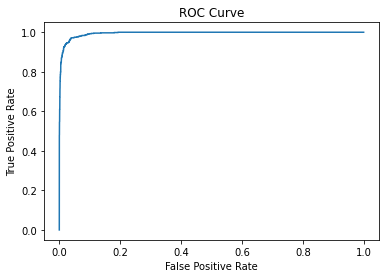

In [ ]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#### Precision

In [ ]:
print("Recall = %f" % (recall_score(y_test, y_pred_cb_precision)))
print("Precision = %f" % (precision_score(y_test, y_pred_cb_precision)))
print("Accuracy = %f" % (accuracy_score(y_test, y_pred_cb_precision)))
print("AUC = %f" % (roc_auc_score(y_test, y_pred_cb_precision)))

Recall = 0.905045
Precision = 0.905045
Accuracy = 0.977106
AUC = 0.946014


In [ ]:
scores = cb_precision.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.9944952683386954


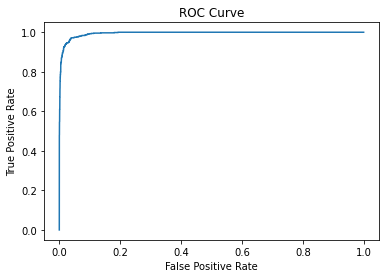

In [ ]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#### Accuracy

In [ ]:
print("Recall = %f" % (recall_score(y_test, y_pred_cb_accuracy)))
print("Precision = %f" % (precision_score(y_test, y_pred_cb_accuracy)))
print("Accuracy = %f" % (accuracy_score(y_test, y_pred_cb_accuracy)))
print("AUC = %f" % (roc_auc_score(y_test, y_pred_cb_accuracy)))

Recall = 0.905045
Precision = 0.905045
Accuracy = 0.977106
AUC = 0.946014


In [ ]:
scores = cb_accuracy.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.9944952683386954


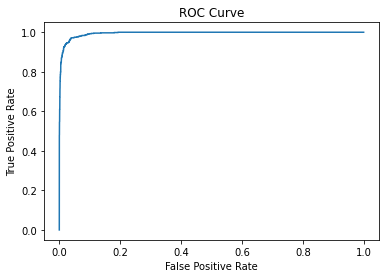

In [ ]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#### Roc AUC

In [ ]:
print("Recall = %f" % (recall_score(y_test, y_pred_cb_auc)))
print("Precision = %f" % (precision_score(y_test, y_pred_cb_auc)))
print("Accuracy = %f" % (accuracy_score(y_test, y_pred_cb_auc)))
print("AUC = %f" % (roc_auc_score(y_test, y_pred_cb_auc)))

Recall = 0.905045
Precision = 0.898380
Accuracy = 0.976212
AUC = 0.945506


In [ ]:
scores = cb_auc.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.9952402764224404


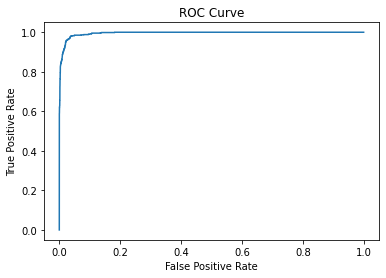

In [ ]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#### Подбор гиперпараметров


In [ ]:
def dt_count_recall_param(best_params, param_name, min_value, max_value, step):
  best_value = 0.0;
  min_score = 0.0;
  values = np.arange(min_value, max_value + step, step)
  for value in values:
    best_params[param_name] = value;
    dt = DecisionTreeClassifier().set_params(**best_params);
    dt.fit(x_train, y_train)
    current_score = recall_score(y_test, dt.predict(x_test))
    if (current_score > min_score):
      min_score = current_score;
      best_value = value;
  print(best_value)
  best_params[param_name] = best_value;
  return best_params;

In [ ]:
dt_best_param = DecisionTreeClassifier(random_state=42).get_params();
dt_best_param = dt_count_recall_param(dt_best_param, "max_depth", 70, 70, 1) # 70
dt_best_param = dt_count_recall_param(dt_best_param, "min_samples_leaf", 0.000005, 0.000005, 0.000005) #0.000005
dt_best_param = dt_count_recall_param(dt_best_param, "max_features", 50, 50, 1) #50


70
5e-06
50
0.0


#### Обучение и предсказание

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(pd.get_dummies(x), y, test_size=1/5, random_state=0)
dt = DecisionTreeClassifier().set_params(**dt_best_param);
dt.fit(pd.get_dummies(x_train), y_train)
y_pred_dt = dt.predict(pd.get_dummies(x_test))

#### Оценка модели

In [ ]:
recall_score(y_test, y_pred_dt)

0.9050445103857567

In [ ]:
precision_score(y_test, y_pred_dt)

0.8615819209039548

In [ ]:
accuracy_score(y_test, y_pred_dt)

0.9710248613843677

## Дерево принятия решений

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(pd.get_dummies(x), y, test_size=1/5, random_state=0)

#### Подбор гиперпараметров


In [ ]:
#Функция для подбора гиперпараметров для лучшей recall оценки
def dt_recall_objective(best_params, param_name, min_value, max_value, step):
  best_value = 0.0;
  min_score = 0.0;
  values = np.arange(min_value, max_value + step, step)
  for value in values:
    best_params[param_name] = value;
    dt = DecisionTreeClassifier().set_params(**best_params);
    dt.fit(x_train, y_train)
    current_score = recall_score(y_test, dt.predict(x_test))
    if (current_score > min_score):
      min_score = current_score;
      best_value = value;
  print(best_value)
  best_params[param_name] = best_value;
  return best_params;

#Функция для подбора гиперпараметров для лучшей accuracy оценки
def dt_accuracy_objective(best_params, param_name, min_value, max_value, step):
  best_value = 0.0;
  min_score = 0.0;
  values = np.arange(min_value, max_value + step, step)
  for value in values:
    best_params[param_name] = value;
    dt = DecisionTreeClassifier().set_params(**best_params);
    dt.fit(x_train, y_train)
    current_score = accuracy_score(y_test, dt.predict(x_test))
    if (current_score > min_score):
      min_score = current_score;
      best_value = value;
  print(best_value)
  best_params[param_name] = best_value;
  return best_params;

#Функция для подбора гиперпараметров для лучшей precision оценки
def dt_precision_objective(best_params, param_name, min_value, max_value, step):
  best_value = 0.0;
  min_score = 0.0;
  values = np.arange(min_value, max_value + step, step)
  for value in values:
    best_params[param_name] = value;
    dt = DecisionTreeClassifier().set_params(**best_params);
    dt.fit(x_train, y_train)
    current_score = precision_score(y_test, dt.predict(x_test))
    if (current_score > min_score):
      min_score = current_score;
      best_value = value;
  print(best_value)
  best_params[param_name] = best_value;
  return best_params;

#Функция для подбора гиперпараметров для лучшей AUC ROC оценки
def dt_roc_auc_objective(best_params, param_name, min_value, max_value, step):
  best_value = 0.0;
  min_score = 0.0;
  values = np.arange(min_value, max_value + step, step)
  for value in values:
    best_params[param_name] = value;
    dt = DecisionTreeClassifier().set_params(**best_params);
    dt.fit(x_train, y_train)
    current_score = roc_auc_score(y_test, dt.predict(x_test))
    if (current_score > min_score):
      min_score = current_score;
      best_value = value;
  print(best_value)
  best_params[param_name] = best_value;
  return best_params;

In [ ]:
#Нахождение гиперпараметров для модели, оптимизированной на оценке recall
dt_recall_best_param = DecisionTreeClassifier(random_state=42).get_params(); # фиксируем параметр рандома, чтобы получать всегда одни и те же данные
dt_recall_best_param = dt_recall_objective(dt_recall_best_param, "max_depth", 1, 100, 1) # ищем оптимальную максимальную глубину в интервале
#max_depth - ограничение на глубину дерева
dt_recall_best_param = dt_recall_objective(dt_recall_best_param, "min_samples_leaf", 0.000005, 0.0005, 0.000005) #min_samples_leaf - минимальное количество элементов в вершине, требуемое для разбиения
# то есть каждый раз дерево, выбирая признак и разбивая по нему, разбивает выборку на части, увеличивая энтропию. Минимальное количество элементов в этой выборке, требуемое для дальнейшего разбиения, задаётся этим параметром
# это количество вычисляется по формуле min_samples_leaf * n_samples, где n_samples - количество элементов в выборке (формула такая, т.к. параметр задаём как float)
dt_recall_best_param = dt_recall_objective(dt_recall_best_param, "max_features", 1, 100, 1) # количество признаков, которое используется для построения модели

30
5e-06
31


In [ ]:
#Нахождение гиперпараметров для модели, оптимизированной на оценке accuracy
dt_accuracy_best_param = DecisionTreeClassifier(random_state=42).get_params();
dt_accuracy_best_param = dt_accuracy_objective(dt_accuracy_best_param, "max_depth", 1, 100, 1)
dt_accuracy_best_param = dt_accuracy_objective(dt_accuracy_best_param,"min_samples_leaf", 0.000005, 0.0005, 0.000005) 
dt_accuracy_best_param = dt_accuracy_objective(dt_accuracy_best_param, "max_features", 1, 100, 1)

26
5e-06
95


In [ ]:
#Нахождение гиперпараметров для модели, оптимизированной на оценке precision
dt_precision_best_param = DecisionTreeClassifier(random_state=42).get_params();
dt_precision_best_param = dt_precision_objective(dt_precision_best_param, "max_depth", 1, 100, 1) 
dt_precision_best_param = dt_precision_objective(dt_precision_best_param, "min_samples_leaf", 0.000005, 0.0005, 0.000005)
dt_precision_best_param = dt_precision_objective(dt_precision_best_param, "max_features", 1, 100, 1)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



18
5e-06
2


In [ ]:
#Нахождение гиперпараметров для модели, оптимизированной на оценке ROC AUC
dt_precision_roc_auc_param = DecisionTreeClassifier(random_state=42).get_params();
dt_precision_roc_auc_param = dt_roc_auc_objective(dt_precision_roc_auc_param, "max_depth", 1, 100, 1)
dt_precision_roc_auc_param = dt_roc_auc_objective(dt_precision_roc_auc_param, "min_samples_leaf", 0.000005, 0.0005, 0.000005)
dt_precision_roc_auc_param = dt_roc_auc_objective(dt_precision_roc_auc_param, "max_features", 1, 100, 1) 

30
5e-06
98


#### Обучение и предсказание

In [ ]:
#Модель, оптимизированная по оценке recall 
dt_recall = DecisionTreeClassifier().set_params(**dt_recall_best_param);
dt_recall.fit(x_train, y_train)
y_pred_dt_recall = dt_recall.predict(x_test)

#Модель, оптимизированная по оценке precision
dt_precision = DecisionTreeClassifier().set_params(**dt_precision_best_param);
dt_precision.fit(x_train, y_train)
y_pred_dt_precision = dt_precision.predict(x_test)

#Модель, оптимизированная по оценке accuracy
dt_accuracy = DecisionTreeClassifier().set_params(**dt_accuracy_best_param);
dt_accuracy.fit(x_train, y_train)
y_pred_dt_accuracy = dt_accuracy.predict(x_test)

#Модель, оптимизированная по оценке ROC AUC
dt_roc_auc = DecisionTreeClassifier().set_params(**dt_precision_roc_auc_param);
dt_roc_auc.fit(x_train, y_train)
y_pred_dt_roc_auc = dt_roc_auc.predict(x_test)

#### Оценка модели

##### Оценка Recall модели

In [ ]:
print("Recall = %f" % (recall_score(y_test, y_pred_dt_recall)))
print("Precision = %f" % (precision_score(y_test, y_pred_dt_recall)))
print("Accuracy = %f" % (accuracy_score(y_test, y_pred_dt_recall)))
print("AUC = %f" % (roc_auc_score(y_test, y_pred_dt_recall)))

Recall = 0.902077
Precision = 0.852735
Accuracy = 0.969415
AUC = 0.940361


In [ ]:
scores = dt_recall.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.9525878847020783


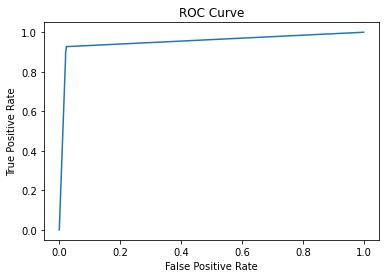

In [ ]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

##### Оценка Precision модели

In [ ]:
print("Recall = %f" % (recall_score(y_test, y_pred_dt_precision)))
print("Precision = %f" % (precision_score(y_test, y_pred_dt_precision)))
print("Accuracy = %f" % (accuracy_score(y_test, y_pred_dt_precision)))
print("AUC = %f" % (roc_auc_score(y_test, y_pred_dt_precision)))

Recall = 0.393175
Precision = 0.910653
Accuracy = 0.922196
AUC = 0.693944


Как мы можем заметить, модель получилась крайне плохой. Причина заключается в несбалансированной выборке - в наших данных больше пациентов, которым не требуется перевод в отделение интенсивной терапии. Поэтому модели проще говорить на большинство признаков, что перевод не требуется - и в большинстве случаев она будет угадывать! Об этом говорит высокая точность и очень низкая полнота

In [ ]:
scores = dt_precision.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.9310601987050318


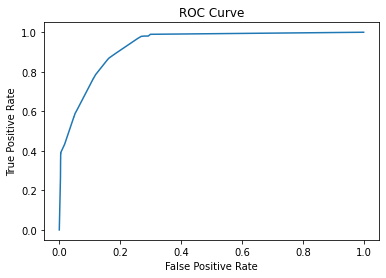

In [ ]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#### Оценка Accuracy модели

In [ ]:
print("Recall = %f" % (recall_score(y_test, y_pred_dt_accuracy)))
print("Precision = %f" % (precision_score(y_test, y_pred_dt_accuracy)))
print("Accuracy = %f" % (accuracy_score(y_test, y_pred_dt_accuracy)))
print("AUC = %f" % (roc_auc_score(y_test, y_pred_dt_accuracy)))

Recall = 0.894659
Precision = 0.879009
Accuracy = 0.972456
AUC = 0.938889


In [ ]:
scores = dt_accuracy.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.9528277718736364


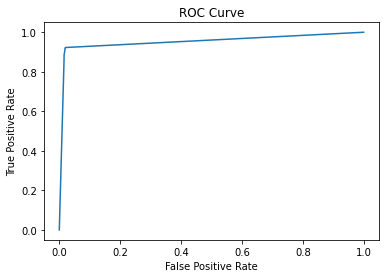

In [ ]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#### Оценка ROC AUC модели 

In [ ]:
print("Recall = %f" % (recall_score(y_test, y_pred_dt_roc_auc)))
print("Precision = %f" % (precision_score(y_test, y_pred_dt_roc_auc)))
print("Accuracy = %f" % (accuracy_score(y_test, y_pred_dt_roc_auc)))
print("AUC = %f" % (roc_auc_score(y_test, y_pred_dt_roc_auc)))

Recall = 0.899110
Precision = 0.874459
Accuracy = 0.972277
AUC = 0.940708


In [ ]:
scores = dt_roc_auc.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.9524101569737162


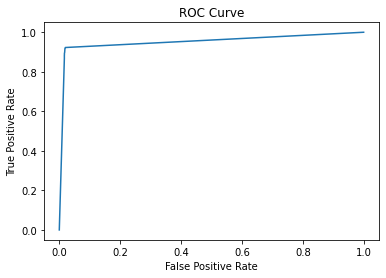

In [ ]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Классификатор LGBM

### Подбор гиперпараметров

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(pd.get_dummies(x), y, test_size=1/5, random_state=0)

In [ ]:
#Функция для подбора гиперпараметров для лучшей recall оценки
def lb_recall_objective(best_params, param_name, min_value, max_value, step):
  best_value = 0.0;
  min_score = 0.0;
  values = np.arange(min_value, max_value + step, step)
  for value in values:
    best_params[param_name] = value;
    lb = LGBMClassifier().set_params(**best_params);
    lb.fit(pd.get_dummies(x_train), y_train)
    current_score = recall_score(y_test, lb.predict(x_test))
    if (current_score > min_score):
      min_score = current_score;
      best_value = value;
  print(best_value)
  best_params[param_name] = best_value;
  return best_params;

#Функция для подбора гиперпараметров для лучшей precision оценки
def lb_precision_objective(best_params, param_name, min_value, max_value, step):
  best_value = 0.0;
  min_score = 0.0;
  values = np.arange(min_value, max_value + step, step)
  for value in values:
    best_params[param_name] = value;
    lb = LGBMClassifier().set_params(**best_params);
    lb.fit(pd.get_dummies(x_train), y_train)
    current_score = precision_score(y_test, lb.predict(x_test))
    if (current_score > min_score):
      min_score = current_score;
      best_value = value;
  print(best_value)
  best_params[param_name] = best_value;
  return best_params;

#Функция для подбора гиперпараметров для лучшей accuracy оценки
def lb_accuracy_objective(best_params, param_name, min_value, max_value, step):
  best_value = 0.0;
  min_score = 0.0;
  values = np.arange(min_value, max_value + step, step)
  for value in values:
    best_params[param_name] = value;
    lb = LGBMClassifier().set_params(**best_params);
    lb.fit(pd.get_dummies(x_train), y_train)
    current_score = accuracy_score(y_test, lb.predict(x_test))
    if (current_score > min_score):
      min_score = current_score;
      best_value = value;
  print(best_value)
  best_params[param_name] = best_value;
  return best_params;

#Функция для подбора гиперпараметров для лучшей ROC AUC оценки
def lb_roc_auc_score_objective(best_params, param_name, min_value, max_value, step):
  best_value = 0.0;
  min_score = 0.0;
  values = np.arange(min_value, max_value + step, step)
  for value in values:
    best_params[param_name] = value;
    lb = LGBMClassifier().set_params(**best_params);
    lb.fit(pd.get_dummies(x_train), y_train)
    current_score = roc_auc_score(y_test, lb.predict(x_test))
    if (current_score > min_score):
      min_score = current_score;
      best_value = value;
  print(best_value)
  best_params[param_name] = best_value;
  return best_params;

In [ ]:
#Нахождение гиперпараметров для модели, оптимизированной на оценке recall
lb_recall_best_param = LGBMClassifier().get_params();
lb_recall_best_param = lb_recall_objective(lb_recall_best_param, "colsample_bytree", 0.005, 1, 0.005) # Соотношение столбцов в подвыборке при построении каждого дерева.
lb_recall_best_param = lb_recall_objective(lb_recall_best_param, "learning_rate", 0.005, 1, 0.005) # подбираем шаг для обучения
lb_recall_best_param = lb_recall_objective(lb_recall_best_param, "max_depth", -1, 30, 1) # подбираем максимальную глубину деревьев
lb_recall_best_param = lb_recall_objective(lb_recall_best_param, "min_child_samples", 0, 50, 1) # Минимальное количество элементов выборки в листе
lb_recall_best_param = lb_recall_objective(lb_recall_best_param, "min_child_weight", 0.0005, 0.2, 0.0005) # Минимальная сумма весов элементов в листе
lb_recall_best_param = lb_recall_objective(lb_recall_best_param, "min_split_gain", 0.005, 2, 0.005) # Минимальное снижение потерь, необходимое для дальнейшего разбиения
lb_recall_best_param = lb_recall_objective(lb_recall_best_param, "n_estimators", 1, 200, 1) # Количество деревьев в модели
lb_recall_best_param = lb_recall_objective(lb_recall_best_param, "num_leaves", 2, 60, 1) # Максимальное количество листьев из вершины
lb_recall_best_param = lb_recall_objective(lb_recall_best_param, "reg_alpha", 0, 2, 0.01) # Параметр L1-регуляризации (отбираем только важные признаки, отбрасывая те, которые предсказывают шум)
lb_recall_best_param = lb_recall_objective(lb_recall_best_param, "reg_lambda", 0, 2, 0.01) # Параметр L2-регуляризации (штрафуем модель за переобучение, то есть за слишком большие веса)
lb_recall_best_param = lb_recall_objective(lb_recall_best_param, "subsample", 0.05, 1, 0.05) # Размер подвыборок для обучения
lb_recall_best_param = lb_recall_objective(lb_recall_best_param, "subsample_for_bin", 10000, 1000000, 10000) # Количество элементов выборки для построения модели

0.8200000000000001
0.47000000000000003
-1
2
0.08750000000000001
0.005
122
57
0.0
0.0
0.05
30000


In [ ]:
#Нахождение гиперпараметров для модели, оптимизированной на оценке precision
lb_precision_best_params = LGBMClassifier().get_params();
lb_precision_best_params = lb_precision_objective(lb_precision_best_params, "colsample_bytree", 0.005, 1, 0.005) #0.735 0.9
lb_precision_best_params = lb_precision_objective(lb_precision_best_params, "learning_rate", 0.005, 1, 0.005) # 0.91 0.56
lb_precision_best_params = lb_precision_objective(lb_precision_best_params, "max_depth", -1, 30, 1) #23 -1
lb_precision_best_params = lb_precision_objective(lb_precision_best_params, "min_child_samples", 0, 50, 1) #11 7
lb_precision_best_params = lb_precision_objective(lb_precision_best_params, "min_child_weight", 0.0005, 0.2, 0.0005) #0.0345 0.071
lb_precision_best_params = lb_precision_objective(lb_precision_best_params, "min_split_gain", 0.005, 2, 0.005) #0.355 0.005
lb_precision_best_params = lb_precision_objective(lb_precision_best_params, "n_estimators", 1, 200, 1) #90 120
lb_precision_best_params = lb_precision_objective(lb_precision_best_params, "num_leaves", 2, 60, 1) #31 55
lb_precision_best_params = lb_precision_objective(lb_precision_best_params, "reg_alpha", 0, 2, 0.01) #0.0 0.0 
lb_precision_best_params = lb_precision_objective(lb_precision_best_params, "reg_lambda", 0, 2, 0.01) #0.0 0.0
lb_precision_best_params = lb_precision_objective(lb_precision_best_params, "subsample", 0.05, 1, 0.05) #0.05 0.05
lb_precision_best_params = lb_precision_objective(lb_precision_best_params, "subsample_for_bin", 10000, 1000000, 10000) #30000 30000

0.02


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



0.01


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



-1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metri

0
0.0005
0.005


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metri

83


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metri

25


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metri

0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metri

0.0
0.05


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



20000


In [ ]:
#Нахождение гиперпараметров для модели, оптимизированной на оценке accuracy
lb_accuracy_best_params = LGBMClassifier().get_params();
lb_accuracy_best_params = lb_accuracy_objective(lb_accuracy_best_params, "colsample_bytree", 0.005, 1, 0.005) #0.735 0.9
lb_accuracy_best_params = lb_accuracy_objective(lb_accuracy_best_params, "learning_rate", 0.005, 1, 0.005) # 0.91 0.56
lb_accuracy_best_params = lb_accuracy_objective(lb_accuracy_best_params, "max_depth", -1, 30, 1) #23 -1
lb_accuracy_best_params = lb_accuracy_objective(lb_accuracy_best_params, "min_child_samples", 0, 50, 1) #11 7
lb_accuracy_best_params = lb_accuracy_objective(lb_accuracy_best_params, "min_child_weight", 0.0005, 0.2, 0.0005) #0.0345 0.071
lb_accuracy_best_params = lb_accuracy_objective(lb_accuracy_best_params, "min_split_gain", 0.005, 2, 0.005) #0.355 0.005
lb_accuracy_best_params = lb_accuracy_objective(lb_accuracy_best_params, "n_estimators", 1, 200, 1) #90 120
lb_accuracy_best_params = lb_accuracy_objective(lb_accuracy_best_params, "num_leaves", 2, 60, 1) #31 55
lb_accuracy_best_params = lb_accuracy_objective(lb_accuracy_best_params, "reg_alpha", 0, 2, 0.01) #0.0 0.0 
lb_accuracy_best_params = lb_accuracy_objective(lb_accuracy_best_params, "reg_lambda", 0, 2, 0.01) #0.0 0.0
lb_accuracy_best_params = lb_accuracy_objective(lb_accuracy_best_params, "subsample", 0.05, 1, 0.05) #0.05 0.05
lb_accuracy_best_params = lb_accuracy_objective(lb_accuracy_best_params, "subsample_for_bin", 10000, 1000000, 10000) #30000 30000

0.6950000000000001
0.52
15
8
0.129
0.005
101
48
0.0
0.0
0.05
30000


In [ ]:
#Нахождение гиперпараметров для модели, оптимизированной на оценке ROC AUC
lb_roc_auc_best_params = LGBMClassifier().get_params();
lb_roc_auc_best_params = lb_roc_auc_score_objective(lb_roc_auc_best_params, "colsample_bytree", 0.005, 1, 0.005) #0.735 0.9
lb_roc_auc_best_params = lb_roc_auc_score_objective(lb_roc_auc_best_params, "learning_rate", 0.005, 1, 0.005) # 0.91 0.56
lb_roc_auc_best_params = lb_roc_auc_score_objective(lb_roc_auc_best_params, "max_depth", -1, 30, 1) #23 -1
lb_roc_auc_best_params = lb_roc_auc_score_objective(lb_roc_auc_best_params, "min_child_samples", 0, 50, 1) #11 7
lb_roc_auc_best_params = lb_roc_auc_score_objective(lb_roc_auc_best_params, "min_child_weight", 0.0005, 0.2, 0.0005) #0.0345 0.071
lb_roc_auc_best_params = lb_roc_auc_score_objective(lb_roc_auc_best_params, "min_split_gain", 0.005, 2, 0.005) #0.355 0.005
lb_roc_auc_best_params = lb_roc_auc_score_objective(lb_roc_auc_best_params, "n_estimators", 1, 200, 1) #90 120
lb_roc_auc_best_params = lb_roc_auc_score_objective(lb_roc_auc_best_params, "num_leaves", 2, 60, 1) #31 55
lb_roc_auc_best_params = lb_roc_auc_score_objective(lb_roc_auc_best_params, "reg_alpha", 0, 2, 0.01) #0.0 0.0 
lb_roc_auc_best_params = lb_roc_auc_score_objective(lb_roc_auc_best_params, "reg_lambda", 0, 2, 0.01) #0.0 0.0
lb_roc_auc_best_params = lb_roc_auc_score_objective(lb_roc_auc_best_params, "subsample", 0.05, 1, 0.05) #0.05 0.05
lb_roc_auc_best_params = lb_roc_auc_score_objective(lb_roc_auc_best_params, "subsample_for_bin", 10000, 1000000, 10000) #30000 30000

0.8200000000000001
0.47000000000000003
-1
2
0.08750000000000001
0.005
140
57
0.0
0.0
0.05
30000


### Обучение и предсказание

In [ ]:
#Модель, оптимизированная по оценке recall 
lb_recall = LGBMClassifier().set_params(**lb_recall_best_param)
lb_recall.fit(x_train, y_train)
lb_recall_pred_y = lb_recall.predict(x_test)

#Модель, оптимизированная по оценке precision
lb_precision = LGBMClassifier().set_params(**lb_precision_best_params)
lb_precision.fit(x_train, y_train)
lb_precision_pred_y = lb_precision.predict(x_test)

#Модель, оптимизированная по оценке accuracy
lb_accuracy = LGBMClassifier().set_params(**lb_accuracy_best_params)
lb_accuracy.fit(x_train, y_train)
lb_accuracy_pred_y = lb_accuracy.predict(x_test)

#Модель, оптимизированная по оценке ROC AUC
lb_roc_auc = LGBMClassifier().set_params(**lb_roc_auc_best_params)
lb_roc_auc.fit(x_train, y_train)
lb_roc_auc_pred_y = lb_roc_auc.predict(x_test)

### Оценка модели

#### Оценка Recall модели

In [ ]:
print("Recall = %f" % (recall_score(y_test, lb_recall_pred_y)))
print("Precision = %f" % (precision_score(y_test, lb_recall_pred_y)))
print("Accuracy = %f" % (accuracy_score(y_test, lb_recall_pred_y)))
print("AUC = %f" % (roc_auc_score(y_test, lb_recall_pred_y)))

Recall = 0.908012
Precision = 0.903988
Accuracy = 0.977285
AUC = 0.947396


In [ ]:
scores = lb_recall.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.9927747190906133


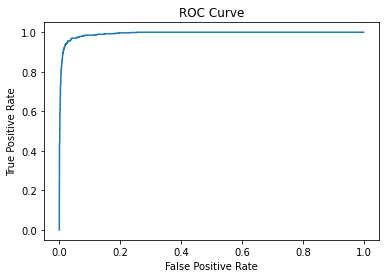

In [ ]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#### Оценка Precision модели

In [ ]:
print("Recall = %f" % (recall_score(y_test, lb_precision_pred_y)))
print("Precision = %f" % (precision_score(y_test, lb_precision_pred_y)))
print("Accuracy = %f" % (accuracy_score(y_test, lb_precision_pred_y)))
print("AUC = %f" % (roc_auc_score(y_test, lb_precision_pred_y)))

Recall = 0.011869
Precision = 1.000000
Accuracy = 0.880880
AUC = 0.505935


Как мы можем заметить, модель получилась крайне плохой. Причина заключается в несбалансированной выборке - в наших данных больше пациентов, которым не требуется перевод в отделение интенсивной терапии. Поэтому модели проще говорить на большинство признаков, что перевод не требуется - и в большинстве случаев она будет угадывать! Об этом говорит высокая точность и очень низкая полнота

In [ ]:
scores = lb_precision.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.9549822302446125


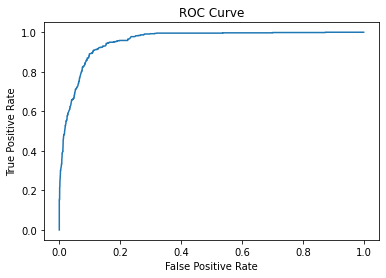

In [ ]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#### Оценка Accuracy модели

In [ ]:
print("Recall = %f" % (recall_score(y_test, lb_accuracy_pred_y)))
print("Precision = %f" % (precision_score(y_test, lb_accuracy_pred_y)))
print("Accuracy = %f" % (accuracy_score(y_test, lb_accuracy_pred_y)))
print("AUC = %f" % (roc_auc_score(y_test, lb_accuracy_pred_y)))

Recall = 0.909496
Precision = 0.908148
Accuracy = 0.978000
AUC = 0.948443


In [ ]:
scores = lb_accuracy.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.9911363953195751


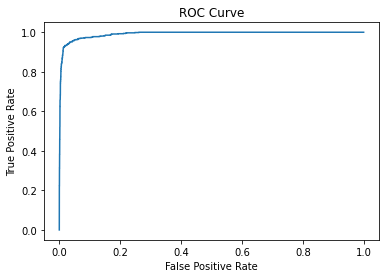

In [ ]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

#### Оценка ROC AUC модели

In [ ]:
print("Recall = %f" % (recall_score(y_test, lb_roc_auc_pred_y)))
print("Precision = %f" % (precision_score(y_test, lb_roc_auc_pred_y)))
print("Accuracy = %f" % (accuracy_score(y_test, lb_roc_auc_pred_y)))
print("AUC = %f" % (roc_auc_score(y_test, lb_roc_auc_pred_y)))

Recall = 0.908012
Precision = 0.903988
Accuracy = 0.977285
AUC = 0.947396


In [ ]:
scores = lb_roc_auc.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)

AUC of ROC Curve: 0.9927747190906133


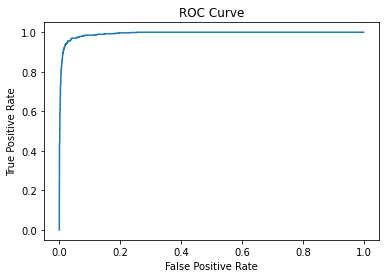

In [ ]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Выводы


## Полученные результаты:

##### - Нам удалось предобработать данные, но в них слишком много пропусков. Некоторую часть удалось заполнить средними значениями, чтобы построить модели, но большинство признаков, по-нашему мнению, не подлежат восстновлению. Поэтому для лучшего результата было бы неплохо получить менее разреженный датасет 

##### - Мы обучили 3 типа моделей: Catboost, DecisionTree и LGBM, подобрав для них гипер-параметры с оптимизацией по четырём ошибкам: Recall, Precision, Accuracy и ROC AUC.

##### - Catboost дал лучший результат - в связи со сложностью модели в целом многие параметры подбираются автоматически даже без нашего вмешательства, что даёт хороший результат. Более того, Catboost самостоятельно следит за переобучением - поэтому поиск гипер-параметров даже на примитичных ошибках даёт отличный результат

##### DecisionTree и LGBM тоже дали хорошие результаты после подбора параметров, но всё же они хуже, чем у моделей CatBoost. Более того, мы убедились, что максимизация примитивных критериев, таких как Precision, не всегда даёт результат - данные модели не защищены от переобучения, поэтому на максимизации Precision они выдали совсем плохую модель, которая хоть и максимизирует оценку, но выдаёт совсем неверные данные

##### Не нам решать, какую оценка важнее. Recall очень полезен для полного охвата пациентов, которым необходима интенсивная терапия, поэтому этот критерий важен.

##### С другой стороны, больницы не могут принимать бесконечное количество больных, поэтому важно, чтобы модель была точна в своих ответах и не отправляла пациентов в отделение без необходимости - то есть важны Accuracy и Precision

##### А ROC AUC позволяет нам сказать, что практически все наши модели хорошо классифицируют пациентов и что взяв всех пациентов, для которых модель выдаёт 1, мы на самом деле поместим в отделение интенсивной терапии всех необходимых больных

##### Но, конечно же, это не всё. Для обучения этой модели очень полезны будут дополнительные данные - новые виды анализов или новые данные для существующих, чтобы модель ещё лучше могла классифицировать пациентов!

И напоследок мы возьмём лучшую модель (CatBoost accuracy), и покажем, какие признаки она посчитала важными

In [ ]:
sorted(
    zip(x_train.columns, cb_accuracy.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)

[('Пребывание(дни)', 24.730315110262993),
 ('Возраст', 20.038131975095332),
 ('ПрофильМедицинскойПомощи', 11.619763263885856),
 ('Подразделение', 8.691111250459077),
 ('ВозрастнойПериод', 8.396687603881833),
 ('ВидТранспортировки', 8.306272751958568),
 ('Пол', 5.652197081442566),
 ('ВидРезультата_Средний объем тромб (MPV)', 1.0970639331988468),
 ('Состояние', 1.0360146647401025),
 ('СрочностьГоспитализации', 0.970704644474249),
 ('ВидРезультата_Прозрачность', 0.8381015709262596),
 ('ВидРезультата_Кислотность', 0.6672133513512606),
 ('ВидРезультата_Лейкоциты (WBC)', 0.6343646355213255),
 ('ВидРезультата_Цвет', 0.5864540777406505),
 ('ВидРезультата_Эпителий плоский', 0.5750004327720751),
 ('ВидРезультата_Кетоны', 0.4595491393037457),
 ('ВидРезультата_Процент эозин(EOS%)', 0.3495506284828631),
 ('ВидРезультата_Температура', 0.32233895130541906),
 ('ВидРезультата_Ширина распред. тромб. (PDW)', 0.2856669692139525),
 ('ВидРезультата_Процент моноц(MONO%)', 0.26762306576628553),
 ('ВидРезульта

##### Как мы можем видеть, анализы не играют значительной роли, хоть в совокупности и помогают дать модели правильный ответ. Наиболее важными критериями модель считает возраст и количество дней, проведённое в больнице.